<a href="https://colab.research.google.com/github/Allzer/Machine_learning/blob/main/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split #разбивает данные для тестирования и тренировки

#библиотеки курса
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#загружаем тестовые данные
def load_data_mat(filename, max_samples, seed=64):
    raw = sio.loadmat(filename) #загружаем файл
    x = raw['X'] #Передаём массивы принадлежащие Х
    y = raw['y'] #Передаём массивы принадлежащие у

    x = np.moveaxis(x, [3], [0]) #Перемещение оси массива. 3 ось мы ставим на нулевую
    y = y.flatten() #Возвращает одномерный массив (для уменьшения массива до одного измерения)

    y[y == 10] = 0 #все значения 10 присваивается знаение 0

    np.random.seed(seed)
    samples = np.random.choice(np.arange(x.shape[0]), max_samples, replace=False) #x.shape[0] передаёт в данном случае
    #рандомную строку 2D массива
    #np.choice - вернет max_sample случайных чисeл от 0 до x.shape[0].
    return x[samples].astype(np.float32), y[samples] #возвращаем массив иксов и игриков с одинаковыми семплами

def load_svhn(folder, max_train, max_test):

    #train_x - массив (num_train,32,32,3) - тренировочные изображения
    #train_y - массив (num_train) - training labels - тренировочный разделитель
    #test_X, np array (num_test, 32, 32, 3) - тестовые изображения
    #test_y, np array of int (num_test) - тестовый разделитель

    train_X, train_y = load_data_mat(os.path.join(folder, "train_32x32.mat"), max_train) #Загружает данные для тренировки
    test_X, test_y = load_data_mat(os.path.join(folder, "test_32x32.mat"), max_test) #Загружает данные для тестов
    return train_X, train_y, test_X, test_y #Возвращает загруенные данные

def random_split_train_val(X, y, num_val, seed=35):
    '''
    Randomly splits dataset into training and validation

    Arguments:
    X - np-массив с выборками
    y - np-массив с метками
    num_val - количество образцов для проверки
    seed - random seed

    Returns:
    train_X, np array (num_train, 32, 32, 3) - обучающие изображения
    train_y, np array of int (num_train) - обучающие метки
    val_X, np array (num_val, 32, 32, 3) - validation images
    val_y, np array of int (num_val) - validation labels
    '''
    np.random.seed(seed)

    indices = np.arange(X.shape[0]) #передаёт в переменную одномерны массив
    np.random.shuffle(indices) #измените последовательность на месте, перетасовав ее содержимое.

    train_indices = indices[:-num_val] #получаем все элементы массива кроме элемента с индексом -num_val
    train_X = X[train_indices]
    train_y = y[train_indices]

    val_indices = indices[-num_val:]
    val_X = X[val_indices]
    val_y = y[val_indices]

    return train_X, train_y, val_X, val_y

In [ ]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1) / 255
    test_flat = test_X.reshape(test_X.shape[0], -1) / 255

    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image

    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])
    return train_flat_with_ones, test_flat_with_ones

train_X, train_y, test_X, test_y = load_svhn("drive/MyDrive/data", max_train=10000, max_test=1000)
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

Играемся с градиентами!

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).

In [ ]:
CRED = '\033[91m'
CGREN = '\033[42m'
CEND = '\033[0m'
def check_gradient(f, x, delta=1e-5, tol=1e-4):
    """
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Return:
      bool indicating whether gradients match or not
    """
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float

    fx, analytic_grad = f(x)
    analytic_grad = analytic_grad.copy()


    assert analytic_grad.shape == x.shape, (analytic_grad.shape, x.shape)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = 0

        # TODO Copy from previous assignment
        x_plus_h = x.copy()
        x_minus_h = x.copy()

        x_plus_h[ix] += delta
        x_minus_h[ix] -= delta
        #print("X -", x_minus_h)
        #print("X +", x_plus_h)
        numeric_grad_at_ix = (f(x_plus_h)[0] - f(x_minus_h)[0])/(2.*delta)

        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print(CRED + "Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix) + CEND)
            return False

        it.iternext()

    print(CGREN+ "Gradient check passed!" + CEND)
    return True, numeric_grad_at_ix


def check_layer_gradient(layer, x, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the input and output of a layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    output = layer.forward(x)
    #print("OUTPUT", output)
    output_weight = np.random.randn(*output.shape)

    def helper_func(x):
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        grad = layer.backward(d_out)
        return loss, grad

    return check_gradient(helper_func, x, delta, tol)


def check_layer_param_gradient(layer, x, param_name, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for the parameter of the layer

    Arguments:
      layer: neural network layer, with forward and backward functions
      x: starting point for layer input
      param_name: name of the parameter
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    param = layer.params()[param_name]
    initial_w = param.value

    output = layer.forward(x)
    output_weight = np.random.randn(*output.shape)

    def helper_func(w):
        param.value = w
        output = layer.forward(x)
        loss = np.sum(output * output_weight)
        d_out = np.ones_like(output) * output_weight
        layer.backward(d_out)
        grad = param.grad
        return loss, grad

    return check_gradient(helper_func, initial_w, delta, tol)


def check_model_gradient(model, X, y, delta=1e-5, tol=1e-4):
    """
    Checks gradient correctness for all model parameters

    Arguments:
      model: neural network model with compute_loss_and_gradients
      X: batch of input data
      y: batch of labels
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Returns:
      bool indicating whether gradients match or not
    """
    params = model.params()

    for param_key in params:
        print("Checking gradient for %s" % param_key)
        param = params[param_key]
        initial_w = param.value

        def helper_func(w):
            param.value = w
            loss = model.compute_loss_and_gradients(X, y)
            grad = param.grad
            return loss, grad

        if not check_gradient(helper_func, initial_w, delta, tol):
            return False

    return True

In [ ]:
def square(x):
    return x*x, 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Начинаем писать свои функции, считающие аналитический градиент
Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:

Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:

predictions -= np.max(predictions)

In [ ]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-100, 0, 100]))
print(probs)

# Убедитесь, что это работает и для больших чисел тоже!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
print(probs)


[1.38389653e-87 3.72007598e-44 1.00000000e+00]
[1. 0. 0.]


In [ ]:
np.seterr(divide = 'ignore')
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs,1)

5.006760443547122

In [ ]:
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([[1, 0, 0]]), np.array([1]))
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))

Gradient check passed!


<ipython-input-10-42f49b5c0f51>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, np.array([1])), np.array([1, 0, 0], np.float))
<ipython-input-3-f218ed4700ca>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert x.dtype == np.float


(True, 0.2119415576151695)

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов.

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из num_classes оценок, а матрица размерности batch_size, num_classes. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [ ]:
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))

Gradient check passed!
Gradient check passed!


<ipython-input-11-725c44ab9862>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
<ipython-input-11-725c44ab9862>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.

Наконец, реализуем сам линейный классификатор!

In [ ]:
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W,target_index)

И теперь регуляризация

In [ ]:
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Тренировка!

In [ ]:
class linear_classifer:
  def softmax(predictions):
    #Принимаем вектор predictions (получаем его после умножения вектора X @ W)
    pred = predictions.copy()
    pred = pred - np.max(pred)
    Smax = np.zeros(pred.shape)

    it = np.nditer(pred,flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
      ix = it.multi_index
      Smax[ix] = np.exp(pred[ix])/np.sum(np.exp(pred))
      it.iternext()
    return Smax
    raise Exception('Not implemented!')



  def cross_entropy_loss(probs, target_index):
      '''
      Computes cross-entropy loss

      Arguments:
        probs, np array, shape is either (N) or (batch_size, N) -
          probabilities for every class
        target_index: np array of int, shape is (1) or (batch_size) -
          index of the true class for given sample(s)

      Returns:
        loss: single value
      '''
      # TODO implement cross-entropy
      # Your final implementation shouldn't have any loops
      return(-np.log(probs[target_index]))
      raise Exception("Not implemented!")


  def softmax_with_cross_entropy(predictions, target_index):
      '''
      Computes softmax and cross-entropy loss for model predictions,
      including the gradient

      Arguments:
        predictions, np array, shape is either (N) or (batch_size, N) -
          classifier output
        target_index: np array of int, shape is (1) or (batch_size) -
          index of the true class for given sample(s)

      Returns:
        loss, single value - cross-entropy loss
        dprediction, np array same shape as predictions - gradient of predictions by loss value
      '''
      # TODO implement softmax with cross-entropy
      # Your final implementation shouldn't have any loops

      if predictions.ndim == 1:
        predictions_new = predictions - np.max(predictions)
      else:
          maximum = np.max(predictions, axis=1)
          predictions_new = predictions - maximum[:, np.newaxis]
      predictions_new = np.exp(predictions_new)
      predictions_sum = np.sum(predictions_new, axis=(predictions.ndim - 1))
      if predictions.ndim == 1:
          probabilities = predictions_new / predictions_sum
      else:
          probabilities = predictions_new / predictions_sum[:, np.newaxis]

      mask_target = np.zeros(probabilities.shape)
      if probabilities.ndim == 1:
          mask_target[target_index] = 1
      elif target_index.ndim == 1:
          mask_target[tuple(np.arange(0, probabilities.shape[0])), tuple(target_index)] = 1
      else:
          mask_target[tuple(np.arange(0, probabilities.shape[0])), tuple(target_index.T[0])] = 1

      loss = -np.sum(mask_target * np.log(probabilities))

      dprediction = probabilities
      dprediction[mask_target.astype(bool)] = dprediction[mask_target.astype(bool)] - 1

      return loss, dprediction


  def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient

    Arguments:
      W, np array - weights
      reg_strength - float value

    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    '''

    loss = reg_strength * np.trace(np.matmul(W.T, W))   # L2(W) = λ * tr(W.T * W)
    grad = 2 * reg_strength * W                         # dL2(W)/dW = 2 * λ * W

    return loss, grad


  def linear_softmax(X, W, target_index):
      '''
      Performs linear classification and returns loss and gradient over W

      Arguments:
        X, np array, shape (num_batch, num_features) - batch of images
        W, np array, shape (num_features, classes) - weights
        target_index, np array, shape (num_batch) - index of target classes

      Returns:
        loss, single value - cross-entropy loss
        gradient, np.array same shape as W - gradient of weight by loss

      '''
      predictions = np.dot(X, W)
      loss, dprediction = linear_classifer.softmax_with_cross_entropy(predictions, target_index)
      dW = np.dot(X.T, dprediction)

      # TODO implement prediction and gradient over W
      # Your final implementation shouldn't have any loops
      return loss, dW
      raise Exception("Not implemented!")

In [ ]:
class LinearSoftmaxClassifier():
    def __init__(self):
        self.W = None

    def fit(self, X, y, batch_size=100, learning_rate=1e-7, reg=1e-5, epochs=2):
        '''
        Trains linear classifier

        Arguments:
          X, np array (num_samples, num_features) - training data
          y, np array of int (num_samples) - labels
          batch_size, int - batch size to use
          learning_rate, float - learning rate for gradient descent
          reg, float - L2 regularization strength
          epochs, int - number of epochs
        '''

        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y)+1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(batch_size, num_train, batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            # TODO implement generating batches from indices
            # Compute loss and gradients
            # Apply gradient to weights using learning rate
            # Don't forget to add both cross-entropy loss
            # and regularization!

            batch = X[batches_indices[0]]
            target_index = y[batches_indices[0]]
            loss_cross, dW = linear_classifer.linear_softmax(batch, self.W, target_index)
            loss_reg, grad_reg = linear_classifer.l2_regularization(self.W, reg)
            self.W = self.W - learning_rate*(dW+grad_reg)
            loss = loss_reg + loss_cross
            loss_history.append(loss)
            print("Epoch %i, loss: %f" % (epoch, loss))

        return loss_history

    def predict(self, X):
        '''
        Produces classifier predictions on the set

        Arguments:
          X, np array (test_samples, num_features)

        Returns:
          y_pred, np.array of int (test_samples)
        '''
        predictions = np.dot(X, self.W)
        probabilities = linear_classifer.softmax(predictions)
        y_pred = np.argmax(probabilities, axis=1)
        return y_pred


In [ ]:
classifier = LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 690.986289
Epoch 1, loss: 691.113189
Epoch 2, loss: 722.857888
Epoch 3, loss: 727.012217
Epoch 4, loss: 757.146392
Epoch 5, loss: 783.371317
Epoch 6, loss: 880.354906
Epoch 7, loss: 895.022272
Epoch 8, loss: 1101.244859
Epoch 9, loss: 887.108549


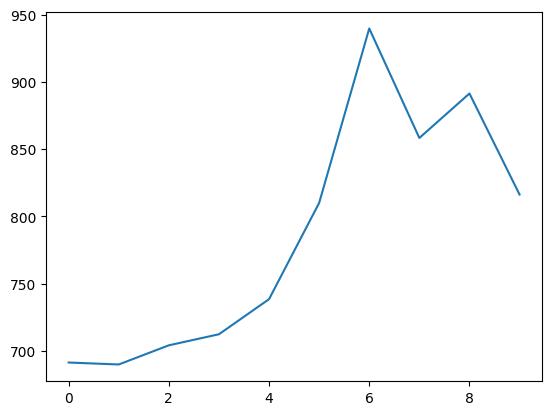

In [ ]:
plt.plot(loss_history)

In [ ]:
def binary_classification_metrics(prediction, ground_truth):
    '''
    Computes metrics for binary classification

    Arguments:
    prediction, np array of bool (num_samples) - model predictions
    ground_truth, np array of bool (num_samples) - true labels

    Returns:
    precision, recall, f1, accuracy - classification metrics
    '''
    tp = np.sum(np.logical_and(prediction, ground_truth))
    fp = np.sum(np.greater(prediction, ground_truth))
    fn = np.sum(np.less(prediction, ground_truth))
    precision = tp/(tp + fp)
    recall = tp/(tp+fn)

    accuracy = np.sum(prediction==ground_truth)/prediction.size
    f1 = precision*recall/(precision+recall)

    return precision, recall, f1, accuracy


def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification

    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels

    Returns:
    accuracy - ratio of accurate predictions to total samples
    '''
    # TODO: Implement computing accuracy

    return accuracy_score(ground_truth, prediction)

In [ ]:
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)


Accuracy:  0.161


In [ ]:
classifier.fit(train_X, train_y, epochs=100, learning_rate=0.000001, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 0, loss: nan
Epoch 1, loss: nan
Epoch 2, loss: nan
Epoch 3, loss: nan
Epoch 4, loss: nan
Epoch 5, loss: nan
Epoch 6, loss: nan
Epoch 7, loss: nan
Epoch 8, loss: nan
Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, 

In [ ]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

best_classifier = ()
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength
# than provided initially

for learning_rate in learning_rates:
    for reg in reg_strengths:
        classifier.fit(train_X, train_y, epochs=num_epochs,
                       learning_rate=learning_rate, batch_size=batch_size, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = (learning_rate, reg)
        print('best validation accuracy achieved: %f' % best_val_accuracy)

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 0, loss: nan
Epoch 1, loss: nan
Epoch 2, loss: nan
Epoch 3, loss: nan
Epoch 4, loss: nan
Epoch 5, loss: nan
Epoch 6, loss: nan
Epoch 7, loss: nan
Epoch 8, loss: nan
Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, 

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 6, loss: nan
Epoch 7, loss: nan
Epoch 8, loss: nan
Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoc

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
E

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
E

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 8, loss: nan
Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Ep

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 8, loss: nan
Epoch 9, loss: nan
Epoch 10, loss: nan
Epoch 11, loss: nan
Epoch 12, loss: nan
Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Ep

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))



Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan

<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 13, loss: nan
Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan
Epoch 64, loss: nan
Epoch 65, loss: nan
Epoch 66, loss: nan
Epoch 67, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan


<ipython-input-14-1ff4a67ab60b>:75: RuntimeWarning: invalid value encountered in multiply
  loss = -np.sum(mask_target * np.log(probabilities))


Epoch 14, loss: nan
Epoch 15, loss: nan
Epoch 16, loss: nan
Epoch 17, loss: nan
Epoch 18, loss: nan
Epoch 19, loss: nan
Epoch 20, loss: nan
Epoch 21, loss: nan
Epoch 22, loss: nan
Epoch 23, loss: nan
Epoch 24, loss: nan
Epoch 25, loss: nan
Epoch 26, loss: nan
Epoch 27, loss: nan
Epoch 28, loss: nan
Epoch 29, loss: nan
Epoch 30, loss: nan
Epoch 31, loss: nan
Epoch 32, loss: nan
Epoch 33, loss: nan
Epoch 34, loss: nan
Epoch 35, loss: nan
Epoch 36, loss: nan
Epoch 37, loss: nan
Epoch 38, loss: nan
Epoch 39, loss: nan
Epoch 40, loss: nan
Epoch 41, loss: nan
Epoch 42, loss: nan
Epoch 43, loss: nan
Epoch 44, loss: nan
Epoch 45, loss: nan
Epoch 46, loss: nan
Epoch 47, loss: nan
Epoch 48, loss: nan
Epoch 49, loss: nan
Epoch 50, loss: nan
Epoch 51, loss: nan
Epoch 52, loss: nan
Epoch 53, loss: nan
Epoch 54, loss: nan
Epoch 55, loss: nan
Epoch 56, loss: nan
Epoch 57, loss: nan
Epoch 58, loss: nan
Epoch 59, loss: nan
Epoch 60, loss: nan
Epoch 61, loss: nan
Epoch 62, loss: nan
Epoch 63, loss: nan


In [ ]:
classifier.fit(train_X, train_y, epochs=num_epochs,
                       learning_rate=best_classifier[0], batch_size=batch_size, reg=best_classifier[0])
test_pred = classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Epoch 0, loss: 602.237255
Epoch 1, loss: 621.579937
Epoch 2, loss: 615.313953
Epoch 3, loss: 606.309044
Epoch 4, loss: 609.211925
Epoch 5, loss: 623.785754
Epoch 6, loss: 616.367358
Epoch 7, loss: 627.912188
Epoch 8, loss: 612.898803
Epoch 9, loss: 604.885655
Epoch 10, loss: 594.610053
Epoch 11, loss: 621.344240
Epoch 12, loss: 620.608061
Epoch 13, loss: 614.730756
Epoch 14, loss: 602.900146
Epoch 15, loss: 616.451325
Epoch 16, loss: 611.519521
Epoch 17, loss: 621.623011
Epoch 18, loss: 604.476646
Epoch 19, loss: 618.830230
Epoch 20, loss: 602.920826
Epoch 21, loss: 621.015674
Epoch 22, loss: 628.191929
Epoch 23, loss: 617.871409
Epoch 24, loss: 614.714833
Epoch 25, loss: 616.557445
Epoch 26, loss: 602.975477
Epoch 27, loss: 624.955340
Epoch 28, loss: 631.513708
Epoch 29, loss: 599.776479
Epoch 30, loss: 616.674924
Epoch 31, loss: 613.658335
Epoch 32, loss: 604.142144
Epoch 33, loss: 604.152814
Epoch 34, loss: 613.506202
Epoch 35, loss: 607.738048
Epoch 36, loss: 624.971632
Epoch 37, l